# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(2222022)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The included variables are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1questions"></a>

## <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**1.1** **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

- **1.1.1**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed if it is 15 minutes late or more). This is going to be the response variable for the rest of this question. 


- **1.1.2** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and standardize the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

<a id="q12"></a>

**1.2** **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs, and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>

**1.3** **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.


- **1.3.1** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.


- **1.3.2** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.


- **1.3.3** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>

**1.4** **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.


- **1.4.1** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical). Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.


- **1.4.2** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).


- **1.4.3** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.


- **1.4.4** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 


- **1.4.5** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>

**1.5** **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>

**1.6** **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. minimum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 


<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.



</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed if it is 15 minutes late or more). This is going to be the response variable for the rest of this question. 




</div>

In [3]:
# your code here
flights = pd.read_csv("data/flights.csv")
flights['DELAY_OR_NOT'] = np.where(flights['ARRIVAL_DELAY'] >= 15, 1, 0)

<div class='exercise-r'>

**1.1.2**  Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and standardize the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

<a id="q12"></a>



</div>

In [4]:
# CHECK FOR MISSING VALUES
flights.isnull().sum()
flights[flights['DISTANCE'].isnull()]

# replace na with mean values based on origina and destination
flights.loc[flights['DISTANCE'].isnull(), 'DISTANCE'] = flights[(flights['ORIGIN_AIRPORT']== "BOS") & 
                                                              (flights['DESTINATION_AIRPORT'] == "SFO")]['DISTANCE'].mean()
flights.loc[flights['FLIGHT_COUNT'].isnull(), 'FLIGHT_COUNT'] = flights[(flights['ORIGIN_AIRPORT']== "BOS") & 
                                                              (flights['DESTINATION_AIRPORT'] == "SFO")]['FLIGHT_COUNT'].mean()
flights.loc[flights['SCHEDULED_TIME'].isnull(), 'SCHEDULED_TIME'] = flights[(flights['ORIGIN_AIRPORT']== "BOS") & 
                                                                  (flights['DESTINATION_AIRPORT'] == "SFO")]['SCHEDULED_TIME'].mean()

In [5]:
# ONE-HOT ENCODING
categorical_var = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for i in categorical_var:
    dummies = pd.get_dummies(flights[i], prefix=i)
    flights = flights.join(dummies)
    flights = flights.drop(columns = i)
    
# TRAIN TEST SPLIT
y = flights[['DELAY_OR_NOT']]
X = flights.drop(columns = ['DELAY_OR_NOT', 'ARRIVAL_DELAY'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
                 
# STANDARDIZE
continuous_var = ['MONTH', 'SCHED_DEP_HOUR', 'SCHED_ARR_HOUR','DAY_OF_WEEK','DISTANCE','SCHEDULED_TIME', 'FLIGHT_COUNT']
X_train_scaled = X_train.copy()
features = X_train_scaled[continuous_var]

scaler = StandardScaler().fit(features.values)

features = scaler.transform(features.values)
X_train_scaled[continuous_var] = features

X_test_scaled = X_test.copy()
features = X_test_scaled[continuous_var]
X_test_scaled[continuous_var] = scaler.transform(features.values)

<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs, and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>



</div>

In [6]:
#### Building NN_model
NN_model = tf.keras.models.Sequential(name='Many_layers_neurons')

#### First hidden layer  
NN_model.add(tf.keras.layers.Dense(15, activation='relu',
                                   kernel_initializer='random_uniform', 
                                   bias_initializer='random_uniform',
                                   input_shape=(X_train_scaled.shape[1],)))

#### Second hidden layer  
NN_model.add(tf.keras.layers.Dense(15, activation='relu',
                                   kernel_initializer='random_uniform', 
                                   bias_initializer='random_uniform'))

#### Add the output layer and check the summary
NN_model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))
NN_model.summary()

Model: "Many_layers_neurons"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                12165     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile model
NN_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics = 'accuracy')

# Fit model
history = NN_model.fit(X_train_scaled, y_train, validation_split = 0.2, epochs=100, verbose = 0)

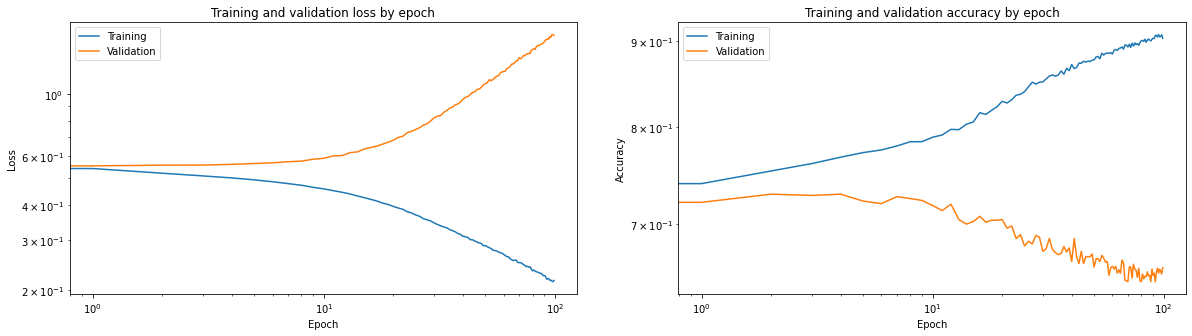

In [8]:
# Plot training and validation loss
def plot_loss_acc(history):
    train_loss = history.history['loss'] 
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(1, 2, figsize = (20,5))
    ax[0].loglog(train_loss, label = 'Training')
    ax[0].loglog(val_loss, label = 'Validation')
    ax[0].set_title('Training and validation loss by epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].loglog(train_acc, label = 'Training')
    ax[1].loglog(val_acc, label = 'Validation')
    ax[1].set_title('Training and validation accuracy by epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()
    pass

plot_loss_acc(history)

**Choice of reasonable number of epochs**

On the plot below we see that with 200 epochs our model starts overfitting, meaning that we can see there is a sheer divergence between validation loss and training loss. At 200 epochs our validation loss is increasing significantly and our training loss is decreasing significantly, meaning that we are overfitting on our training dataset. Given this, now we decide a reasonable number of epochs to be 10 instead of 100. 

In [9]:
#### Building NN_model
NN_model = tf.keras.models.Sequential(name='Many_layers_neurons')

#### First hidden layer  
NN_model.add(tf.keras.layers.Dense(15, activation='relu',
                                   kernel_initializer='random_uniform', 
                                   bias_initializer='random_uniform',
                                   input_shape=(X_train_scaled.shape[1],)))

#### Second hidden layer  
NN_model.add(tf.keras.layers.Dense(15, activation='relu',
                                   kernel_initializer='random_uniform', 
                                   bias_initializer='random_uniform'))

#### Add the output layer and check the summary
NN_model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))

# Compile model
NN_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics = 'accuracy')

# Fit model
history = NN_model.fit(X_train_scaled, y_train, validation_split = 0.2, epochs=10, verbose = 0)

In [10]:
# evaluate on train and test and print accuracy results
train_loss, train_acc = NN_model.evaluate(X_train_scaled, y_train, verbose = 0)
test_loss, test_acc = NN_model.evaluate(X_test_scaled, y_test, verbose = 0)
print(f'Training accuracy: {train_acc: .3f}')
print(f'Test accuracy: {test_acc: .3f}')

Training accuracy:  0.780
Test accuracy:  0.711


<div class='exercise-r'>

**1.3**  **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.




</div>

<div class='exercise-r'>

**1.3.1**  First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.




</div>

In [11]:
# generate prediction
y_predict = np.where((NN_model.predict(X_train_scaled))> 0.5, 1, 0)

<div class='exercise-r'>

**1.3.2**  Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.




</div>

In [12]:
# your code here
logreg = LogisticRegression(penalty='l2', C=10, max_iter = 10000)
logreg.fit(X_train_scaled, np.ravel(y_predict))
y_pred_log = logreg.predict(X_test_scaled)
test_acc_prox = accuracy_score(np.ravel(y_test), y_pred_log)
print(f"Test accuracy of proxy model: {test_acc_prox:.3f}")

Test accuracy of proxy model: 0.719


<div class='exercise-r'>

**1.3.3**  Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>



</div>

In [13]:
# your code here
logreg_imp = permutation_importance(logreg, X_train_scaled, y_train, n_jobs=-1, random_state = 0)

In [14]:
logreg_imp_score = logreg_imp['importances_mean']
logreg_imp_score_norm = logreg_imp_score/logreg_imp_score.max()
top_10_ind = logreg_imp_score_norm.argsort()[-10:]
top_10_var = X_train.columns[top_10_ind]
top_10_var

Index(['ORIGIN_AIRPORT_SEA', 'DESTINATION_AIRPORT_ATL', 'ORIGIN_AIRPORT_LGA',
       'FLIGHT_COUNT', 'DESTINATION_AIRPORT_ORD', 'ORIGIN_AIRPORT_ATL',
       'MONTH', 'DESTINATION_AIRPORT_LGA', 'DAY_OF_WEEK', 'SCHED_DEP_HOUR'],
      dtype='object')

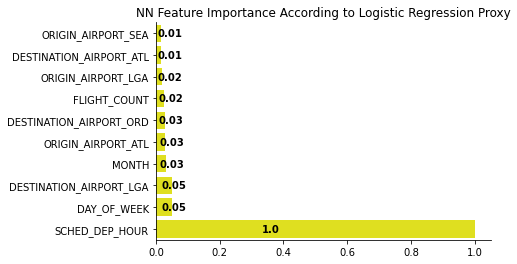

In [15]:
ax = sns.barplot(x=logreg_imp_score_norm[top_10_ind], y=top_10_var, color = 'yellow', orient = 'h')
for index, val in enumerate(logreg_imp_score_norm[top_10_ind]):
    ax.text(val/3, index, round(val, 2), weight = 'bold', va = 'center')
ax.set_title('NN Feature Importance According to Logistic Regression Proxy')
sns.despine(right = True)

<div class='exercise-r'>

**1.4**  **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.




</div>

<div class='exercise-r'>

**1.4.1**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical. Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

 


</div>

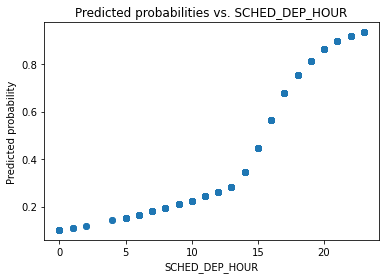

In [16]:
# set all predictors to mean/mode
continuous_var = continuous_var
categorical_var = [i for i in X_train.columns if i not in continuous_var]
X_train_14 = X_train_scaled.copy()
X_train_14[continuous_var] = X_train_14[continuous_var].mean()
for i in categorical_var:
    X_train_14[i] = (X_train_14[i].mode()[0])
X_train_14['SCHED_DEP_HOUR'] = X_train_scaled['SCHED_DEP_HOUR']

# predict
y_pred_14 = NN_model.predict(X_train_14)
plt.scatter(X_train['SCHED_DEP_HOUR'], y_pred_14)
plt.title("Predicted probabilities vs. SCHED_DEP_HOUR") 
plt.xlabel("SCHED_DEP_HOUR")
plt.ylabel("Predicted probability")
plt.show()

**INTERPRETATION:**

- The later the departure hour in the day, the more likely the flight will be delayed.

<div class='exercise-r'>

**1.4.2**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).




</div>

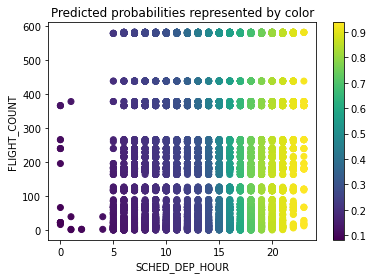

In [17]:
# set all predictors to mean/mode
continuous_var = continuous_var
categorical_var = [i for i in X_train.columns if i not in continuous_var]
X_train_14 = X_train_scaled.copy()
X_train_14[continuous_var] = X_train_14[continuous_var].mean()
for i in categorical_var:
    X_train_14[i] = (X_train_14[i].mode()[0])
X_train_14.head()
X_train_14['SCHED_DEP_HOUR'] = X_train_scaled['SCHED_DEP_HOUR']
X_train_14['FLIGHT_COUNT'] = X_train_scaled['FLIGHT_COUNT']

# predict
y_pred_14 = NN_model.predict(X_train_14)
plt.scatter(X_train['SCHED_DEP_HOUR'], X_train['FLIGHT_COUNT'], c = y_pred_14, cmap = 'viridis')
plt.colorbar()
plt.title("Predicted probabilities represented by color") 
plt.xlabel("SCHED_DEP_HOUR")
plt.ylabel("FLIGHT_COUNT")
plt.show()


<div class='exercise-r'>

**1.4.3**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.




</div>

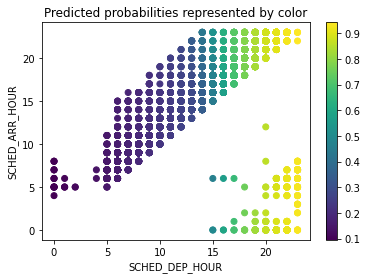

In [18]:
# set all predictors to mean/mode
continuous_var = continuous_var
categorical_var = [i for i in X_train.columns if i not in continuous_var]
X_train_14 = X_train_scaled.copy()
X_train_14[continuous_var] = X_train_14[continuous_var].mean()
for i in categorical_var:
    X_train_14[i] = (X_train_14[i].mode()[0])
X_train_14.head()
X_train_14['SCHED_DEP_HOUR'] = X_train_scaled['SCHED_DEP_HOUR']
X_train_14['SCHED_ARR_HOUR'] = X_train_scaled['SCHED_ARR_HOUR']

# predict
y_pred_14 = NN_model.predict(X_train_14)
plt.scatter(X_train['SCHED_DEP_HOUR'], X_train['SCHED_ARR_HOUR'], c = y_pred_14, cmap = 'viridis')
plt.colorbar()
plt.title("Predicted probabilities represented by color") 
plt.xlabel("SCHED_DEP_HOUR")
plt.ylabel("SCHED_ARR_HOUR")
plt.show()

<div class='exercise-r'>

**1.4.4**  Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 




</div>

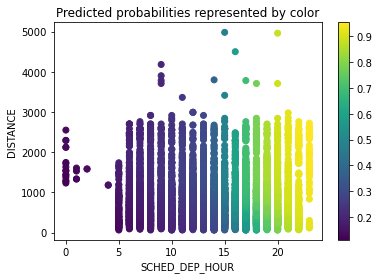

In [19]:
# set all predictors to mean/mode
continuous_var = continuous_var
categorical_var = [i for i in X_train.columns if i not in continuous_var]
X_train_14 = X_train_scaled.copy()
X_train_14[continuous_var] = X_train_14[continuous_var].mean()
for i in categorical_var:
    X_train_14[i] = (X_train_14[i].mode()[0])
X_train_14.head()
X_train_14['SCHED_DEP_HOUR'] = X_train_scaled['SCHED_DEP_HOUR']
X_train_14['DISTANCE'] = X_train_scaled['DISTANCE']

# predict
y_pred_14 = NN_model.predict(X_train_14)
plt.scatter(X_train['SCHED_DEP_HOUR'], X_train['DISTANCE'], c = y_pred_14, cmap = 'viridis')
plt.colorbar()
plt.title("Predicted probabilities represented by color") 
plt.xlabel("SCHED_DEP_HOUR")
plt.ylabel("DISTANCE")
plt.show()

<div class='exercise-r'>

**1.4.5**  In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>



</div>

**INTERPRETATION:**

- In 1.4.1, we observe that when we hold all other variables constant at their means and modes, the predicted probabilitie of delay increases as SCHED_DEP_HOUR increases. This means that keeping all other factors fixed, flights departing later in the day are more likely to be delayed.
- In 1.4.2 - 1.4.4, we relax the constraints of holding fixed other variables for different variables. The plots show that predictied probabilities increase with SCHED_DEP_HOUR, but not with the other variables we examined (SCHED_ARR_HOUR, DISTANCE, and FLIGHT_COUNT). We see that the predicted probabilities, represented by the colors of the scatter points, increase as we move along the x-axes of the plots, but not along the y-axes. 
- This result is consistent with the importance analysis we conducted above. The importance index for SCHED_DEP_HOUR is the highest and is significantly higher than the second most important feature.

<div class='exercise-r'>

**1.5**  **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>



</div>

In [20]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [21]:
# Define a bootstrap function, which takes as input a dataframe 
def bootstrap(df1, df2):
    selectionIndex = np.random.randint(0, df1.shape[0], size = df1.shape[0])
    new_df1 = df1.iloc[selectionIndex]
    new_df2 = df2.iloc[selectionIndex]

    return new_df1, new_df2

# Run bootstrap model and save predictions
n_bootstrap = 50
list_prob_distr_predictions = []

for i in range(n_bootstrap):
    progressbar(i, n_bootstrap)
    boot_x, boot_y = bootstrap(X_train_scaled, y_train)
    NN_model.fit(boot_x, boot_y, epochs=10, verbose = 0)
    y_pred_boot = NN_model.predict(X_test_scaled)
    list_prob_distr_predictions.append(y_pred_boot)

 [==================================================] 50/50 Done...



[ 815  723 1318 1077 1228 1396  664 1679]


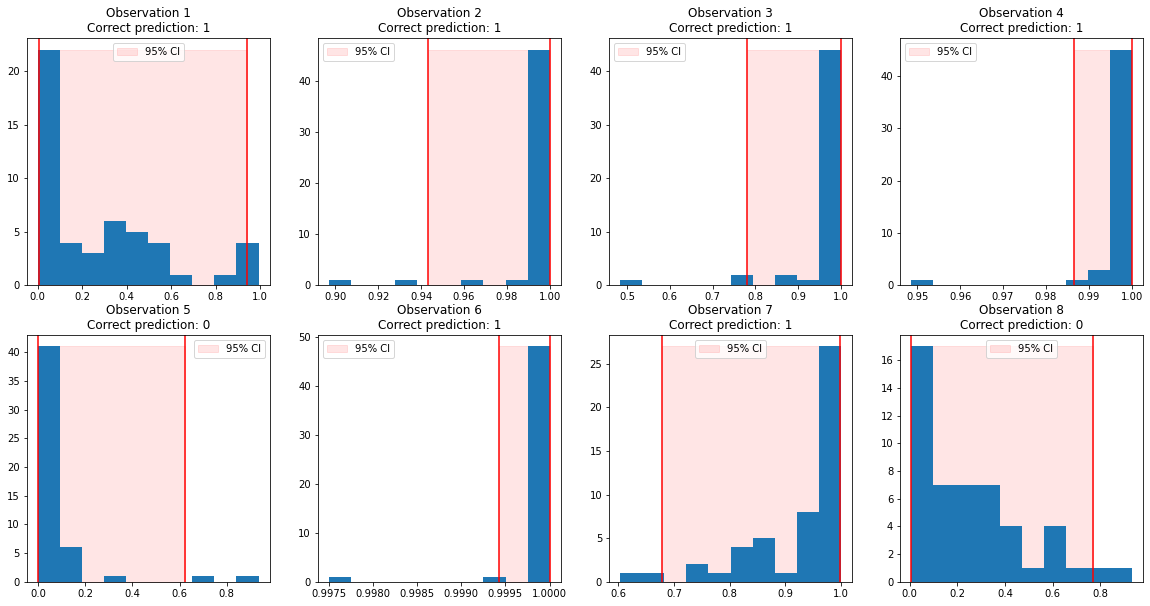

In [22]:
# generate prediction from predicted probs
predicted_prob = np.array(list_prob_distr_predictions)
predicted_label = np.where(predicted_prob > 0.5, 1, 0)

# randomly pick 8 observations
np.random.seed(1234)
rand_int = np.random.randint(0, 2000, size=8)
print(rand_int)
eight_random_obs = predicted_prob[:, rand_int]

# plot distribution
fig, axes = plt.subplots(2, 4, figsize = (20,10))
for i, ax in enumerate(axes.flatten()):
    
    probs = eight_random_obs[:, i]
    correct = y_test.iloc[rand_int[i]][0]
    
    lower_perc = np.percentile(probs, 2.5)
    upper_perc = np.percentile(probs, 97.5)
    height, bins, patches = ax.hist(probs)
    ax.axvline(lower_perc, color = 'red')
    ax.axvline(upper_perc, color = 'red')
    ax.fill_betweenx([0, height.max()], lower_perc, upper_perc, color = 'red', alpha=0.1, label = "95% CI")
    ax.legend()
    ax.set_title(f"Observation {i+1}\nCorrect prediction: " + str(correct))
plt.show()

**INTERPRETATION:**

- For 7 out of 8 of the randomly selected observation, the model predicts correctly but the spread of probability varies.
- For observation 2, 3, 4, and 6, virtually all of the predicted probabilities from the bootstrap model are 1.0, corresponding to the correct classification. The 95% CI for these observations are also very tight. For these observations, our model is very confident and correctly so.
- For observation 7, we see the majority of the predicted probability around 1, corresponding to the correct classification. However, there is more spread compared to the observations in the first bullet point and the 95% CI is wider. While our model is correct here, it is less certain.
- For observation 8, while the highest mass of predicted probability is correctly around 0.0, there is a larger spread of values all the way up to 0.6. Hence, there is more disagreement amongst our bootstrap models for this observation.
- For observation 1, our model predicted the wrong label but was very confident in the wrong prediction.

<div class='exercise-r'>

**1.6**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. minimum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 


</div>

Test accuracy of bagged model: 0.643


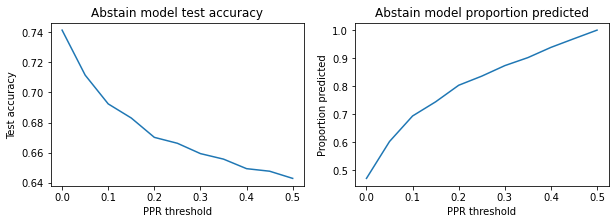

In [23]:
# Calculate PPR for each observation
# PPR: ratio of prediction that is different from final prediction (average prediction)

PPR = 1 - np.maximum(np.mean(predicted_label, axis = 0), (1-np.mean(predicted_label, axis = 0))) #shape 2000 x1 across 50 models
bagged_prediction = np.where(np.mean(predicted_label, axis = 0) > 0.5, 1, 0) # shape is 2000x1

# Test accuracy of bagging model
bag_test_acc = accuracy_score(y_test, bagged_prediction)
print(f"Test accuracy of bagged model: {bag_test_acc:.3f}")

# Abstain model
def abstain_model(PPR_list, bag_pred, y_test, thres):
    pred_abstain, y_test_predicted = [], []
    for i, ppr in enumerate(PPR_list):
        if ppr <= thres: #if the disagreement ratio is below your tolerance for disagreement outcome
            y_test_predicted.append(y_test.iloc[i])
            pred_abstain.append(bagged_prediction[i])
    ab_test_acc = accuracy_score(y_test_predicted, pred_abstain)
    proportion = len(pred_abstain)/len(y_test)
    return ab_test_acc, proportion

thres_list = np.arange(0, 0.55, 0.05)
ab_test_acc, proportion = [], []

for t in thres_list:
    acc, prop = abstain_model(PPR, bagged_prediction, y_test, t)
    ab_test_acc.append(acc)
    proportion.append(prop)

fig, ax = plt.subplots(1, 2, figsize = (10,3))
ax[0].plot(thres_list, ab_test_acc)
ax[0].set_title("Abstain model test accuracy")
ax[0].set_xlabel("PPR threshold")
ax[0].set_ylabel("Test accuracy")
ax[1].plot(thres_list, proportion)
ax[1].set_title("Abstain model proportion predicted")
ax[1].set_xlabel("PPR threshold")
ax[1].set_ylabel("Proportion predicted")
plt.show()

**INTERPRETATION:**

- As we increase the PPR threshold, we relaxing the constraint on certainty and predict on more test observation. Hence, the proportion predicted increases.
- However, as we increase the PPR threshold, we also observe that the model become less accurate and trending closer to the accuracy of the original bagging model. That's because with low PPR threshold, we are stricter with our prediction and only predict when we are certain (or when there is less variability in the prediction of the bootstraps). 

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/af72601cf0ff4e14b60dd4ca62c54b3d). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/af72601cf0ff4e14b60dd4ca62c54b3d). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3](#q23).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 50% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 50% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

<a id="part2questions"></a>

## <div class='exercise'>PART2 Questions</div>

[Return to contents](#contents)


<a id="q21"></a>

**2.1** **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.

<a id="q22"></a>

**2.2** **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="q23"></a>

**2.3** **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

- **2.3.1** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.


- **2.3.2** Plot your model's training accuracy and validation accuracy as a function of epochs.


- **2.3.3** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.


- **2.3.4** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.


- **2.3.5** **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.

<a id="q22"></a>



</div>

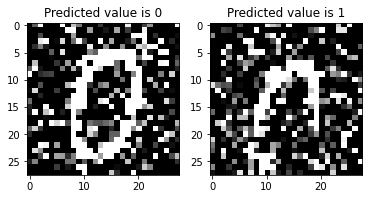

In [25]:
# import data
kmnist_test = pd.read_csv("data/kmnist_test.csv")
kmnist_train = pd.read_csv("data/kmnist_train.csv")

x_test = kmnist_test
x_train = kmnist_train.iloc[:,:-1]
y_train = kmnist_train.iloc[:, -1]

# display
img0 = np.array(x_train.iloc[400, :]).reshape(28,28)
img1 = np.array(x_train.iloc[300, :]).reshape(28,28)
fig, ax = plt.subplots(1, 2)
ax[0].set_title(f'Predicted value is {y_train[400]}')
ax[0].imshow(img0, cmap='gray')
ax[1].set_title(f'Predicted value is {y_train[300]}')
ax[1].imshow(img1, cmap='gray')
plt.show()

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="q23"></a>



</div>

In [26]:
# overfit model
model_overfit = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape = (784,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model_overfit.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

history = model_overfit.fit(x_train, y_train,
                            #validation_data=(x_val,y_val), 
                            validation_split=0.3,
                            batch_size = 128, epochs=1000, verbose=0)

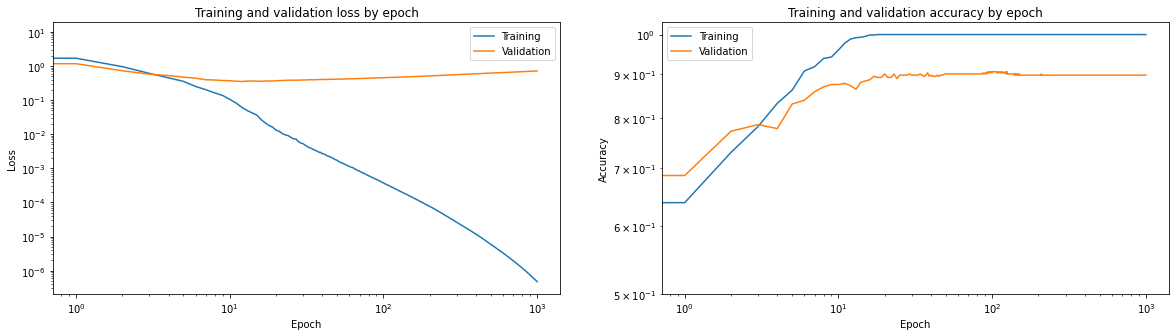

In [27]:
# Plot training and validation loss
plot_loss_acc(history)

**INTERPRETATION**
* The training accuracy after 1000 epochs is 100% while the validation accuracy is only around 50%. We see a large divergence between the two around epoch 10. The large gap between the training and validation loss is sign that the model has overfit to the training data.

<div class='exercise-r'>

**2.3**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import data
kmnist_test = pd.read_csv("data/kmnist_test.csv")
kmnist_train = pd.read_csv("data/kmnist_train.csv")

x_test = kmnist_test
x_train = kmnist_train.iloc[:,:-1]
y_train = kmnist_train.iloc[:, -1]

# Split into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

# Reshape train
x_train_reshaped = np.concatenate([i.reshape(1,28,28)[:,:,:,None] for i in np.array(x_train)])

# generate new data
def add_noise(img):
    VARIABILITY = 20 # customize this
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

datagen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.5,
      height_shift_range=0.5,
      shear_range=0.2,
      zoom_range=0.2,
      preprocessing_function=add_noise,
      horizontal_flip=True,
      fill_mode='nearest',
)

augmented_data = datagen_aug.flow(x_train_reshaped, y_train, batch_size=len(x_train))
x_augmented = augmented_data[0][0].reshape(840,784)
y_augmented = augmented_data[0][1]

# add new data into original train data
x_train_augmented = np.concatenate([x_augmented, np.array(x_train)])
y_train_augmented = np.concatenate([y_augmented, np.array(y_train)])

In [63]:
# train the model
np.random.seed(1234)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=150, restore_best_weights=True, verbose=1)

model_regularised = tf.keras.models.Sequential([
  tf.keras.layers.Dropout(.3, input_shape=(784,)),
  tf.keras.layers.Input(shape = (784,)),
  tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')

])

model_regularised.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'])

history = model_regularised.fit(x_train_augmented, y_train_augmented, 
                                batch_size = 20, 
                                epochs=700, 
                                callbacks=es,
                                validation_data=(x_val,y_val), 
                                #validation_split=0.3,
                                verbose=0)

Restoring model weights from the end of the best epoch: 67.
Epoch 217: early stopping


<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

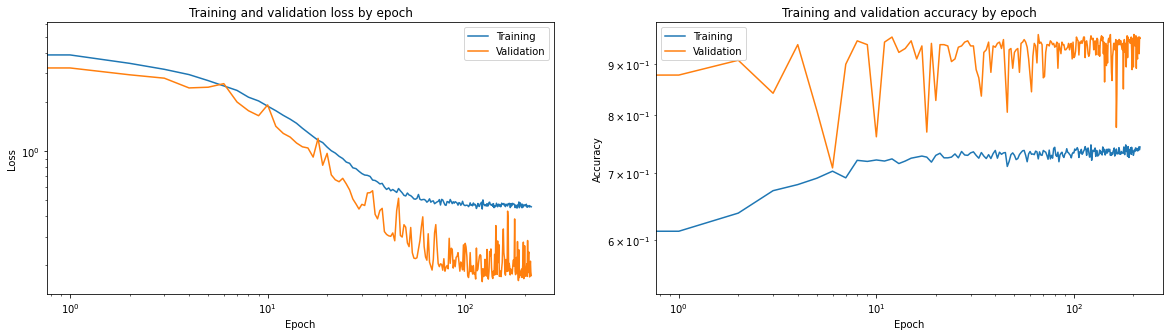

In [64]:
# Plot training and validation loss
plot_loss_acc(history)

In [65]:
print("Training Evaluation")
print(model_regularised.evaluate(x_train_augmented,y_train_augmented))
print("Validation Evaluation")
print(model_regularised.evaluate(x_val,y_val))

Training Evaluation
53/53 [==============================] - 0s 3ms/step - loss: 0.4535 - accuracy: 0.7589
[0.45348137617111206, 0.7589285969734192]
Validation Evaluation
12/12 [==============================] - 0s 3ms/step - loss: 0.2090 - accuracy: 0.9639
[0.20902709662914276, 0.9638888835906982]


<div class='exercise-r'>

**2.3.3**  In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.




</div>

**APPROACH AND OBSERVATIONS:**

* First, we reduce the number of epoch to 700 instead of 1000. We also apply an early stopping criteria to further limite the number of epoch trained to reduce overfitting. Our early stopping criteria has a patience value of 150.
* Another approach we implemented is to include L2 regularization on all the layers in the network to reduce the size of the weights.
* We also added a dropout layer with a probability of 0.3.
* Finally we created an augmented the data using ImageDataGenerator package.

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [66]:
y_predict = np.where((model_regularised.predict(x_test))>= 0.5, 1, 0)
submission1 = pd.DataFrame(y_predict, columns= ['category'])
indexes = np.arange(0, 2000)
submission1_idx = pd.DataFrame(indexes, columns = ['id'])
category_ = submission1['category']
submission = submission1_idx.join(category_)

submission

,id,category
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
1995,1995,1
1996,1996,0
1997,1997,1
1998,1998,0


In [67]:
submission.to_csv('try1_unicorns1.csv',mode = 'w', index=False)

<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**


**cute_unicorns**

[Return to contents](#contents)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=65278b88-5ba3-48f3-bf4e-578b5e939cd0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>